In [1]:
! pip -q install kaggle
! pip -q install opendatasets
! pip -q install pandas

In [3]:
! mkdir /root/.kaggle

In [4]:
! ls /root/.kaggle

In [8]:
from google.colab import files
#import kaggle
import os

# now: import kaggle data set into google colab

In [9]:
files.upload()
# you are supposed to get a kaggle.json file from the Kaggle website. Upload yours here.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zehongwu","key":"071292c82fa4bc0317a4d17245d13eea"}'}

In [10]:
! cp kaggle.json ~/.kaggle

In [11]:
! ls ~/.kaggle -a -l

total 16
drwxr-xr-x 2 root root 4096 Jan 27 18:05 .
drwx------ 1 root root 4096 Jan 27 18:03 ..
-rw-r--r-- 1 root root   64 Jan 27 18:05 kaggle.json


In [12]:
os.chmod("/root/.kaggle/kaggle.json", 600)
# make it so that the file can be accessed

In [13]:
import opendatasets as od
import pandas
import kaggle
od.download(
    "https://www.kaggle.com/datasets/afridirahman/brain-stroke-ct-image-dataset")

100%|██████████| 60.4M/60.4M [00:00<00:00, 63.9MB/s]


In [14]:
! ls -a ./brain-stroke-ct-image-dataset/Brain_Data_Organised/
# ensure that the downloaded data set is where it belongs

.  ..  Normal  Stroke


In [72]:
#!pip install -q tensorflow
# Reference: https://www.tensorflow.org/tutorials/images/classification
# Now: create training and validating data sets using imported Kaggle data
from tensorflow import keras

image_loading_seed = 69420 # use any random number you want

# There is technically no reason to make a train and val sets, since VAEs don't bother with that.
# I will leave my bad code up just in case it becomes useful in another context.

training = keras.utils.image_dataset_from_directory(
    "./brain-stroke-ct-image-dataset/Brain_Data_Organised/",
    labels="inferred",
    label_mode="int",
    class_names=None,
    seed=image_loading_seed,
    color_mode="grayscale",
    validation_split=0.25,
    subset="training")

validating = keras.utils.image_dataset_from_directory(
    "./brain-stroke-ct-image-dataset/Brain_Data_Organised/",
    labels="inferred",
    label_mode="int",
    class_names=None,
    seed=image_loading_seed,
    color_mode="grayscale",
    validation_split=0.25,
    subset="validation")

ValueError: If `subset` is set, `validation_split` must be set, and inversely.

In [16]:
# ensure that the class names are correct
class_names = training.class_names
print(class_names)

['Normal', 'Stroke']


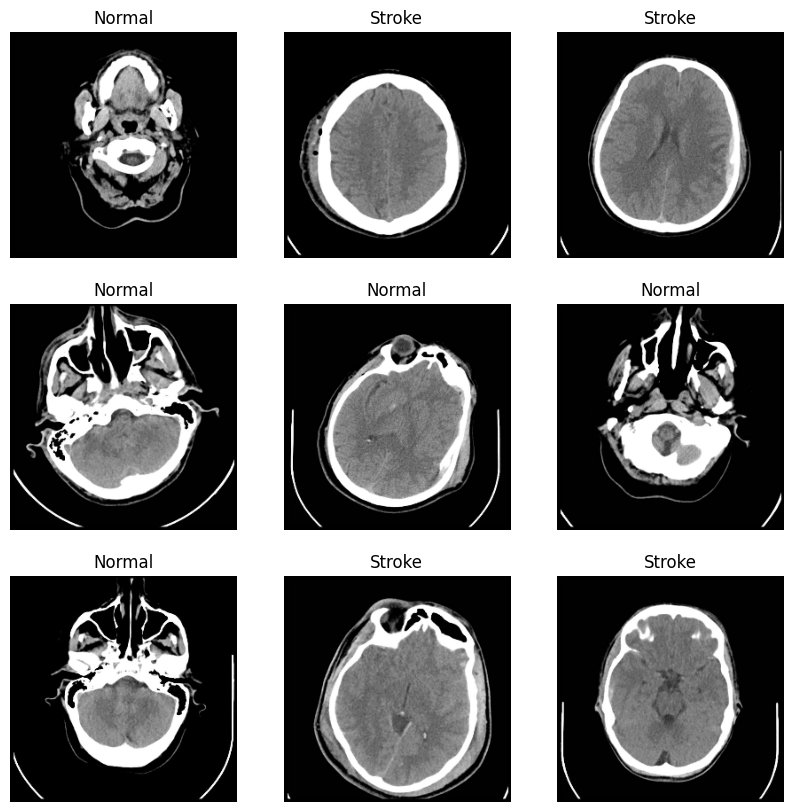

In [17]:
# draw a plot to make sure the data is read right
# reference: https://www.tensorflow.org/tutorials/images/classification

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
# Creating a Variable Autoencoder using a Keras example.
# reference: https://keras.io/examples/generative/vae/
import numpy as np
import tensorflow as tf
from keras import layers

# Sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(256, 256, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
# Modified a few numbers to ensure 256x256 output images.
# Reference:
# https://stackoverflow.com/questions/68862962/variational-autoencoder-keras-logits-and-labels-must-have-the-same-shape

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64 * 64 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((64, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# Define VAE as a model

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 262144)               0         ['conv2d_1[0][0]']            
                                                                                            

In [19]:
# Making sure the data set is right
# reference: https://www.tensorflow.org/tutorials/load_data/images
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  first_image = image_batch[0]
  # Notice the pixel values.
  print(np.min(first_image), np.max(first_image))
  break

(32, 256, 256, 1)
(32,)
0.0 255.0


In [20]:
# Normalize pixels to be in the 0, 1 range.
normalization_layer = keras.layers.Rescaling(1./255)
training = training.map(lambda x, y: (normalization_layer(x), y))
validating = validating.map(lambda x, y: (normalization_layer(x), y))

In [21]:
# A second check of the image pixel values.
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  first_image = image_batch[0]
  # Notice the pixel values.
  print(np.min(first_image), np.max(first_image), np.mean(first_image))
  break

(32, 256, 256, 1)
(32,)
0.0 1.0 0.21235888


In [61]:
# Convert tensors into NumPy arrays.
# This code taken from this reference:
# https://saturncloud.io/blog/how-to-convert-tensorflow-dataset-to-2d-numpy-array/

training_imgs= [img for img, label in training]
training_labels = [label for img, label in training]
validating_imgs = [img for img, label in validating]
validating_labels = [label for img, label in validating]

train_labels = np.array([])
val_labels = np.array([])
training_imgs = np.vstack(training_imgs)
validating_imgs = np.vstack(validating_imgs)
for label in training_labels:
  train_labels = np.concatenate((train_labels, label.numpy()), axis=None)
for label in validating_labels:
  val_labels = np.concatenate((val_labels, label.numpy()), axis=None)

# Due to a fundamental mis-understanding

In [76]:
# Training the VAE
"""
Found 2501 files belonging to 2 classes.
Using 1876 files for training.
Found 2501 files belonging to 2 classes.
Using 625 files for validation.
"""
epochs = 39
batch_size = 64

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy')
# using small epoch and batch size count to cut down on training time
vae.fit(np.concatenate([training_imgs, validating_imgs], axis=0), epochs=epochs, batch_size=batch_size)

Epoch 1/39
40/40 [==============================] - 19s 236ms/step - loss: 20626.2967 - reconstruction_loss: 20582.7656 - kl_loss: 28.2278
Epoch 2/39
40/40 [==============================] - 8s 196ms/step - loss: 20468.9422 - reconstruction_loss: 20292.7246 - kl_loss: 29.9338
Epoch 3/39
40/40 [==============================] - 8s 198ms/step - loss: 20251.6153 - reconstruction_loss: 20243.9590 - kl_loss: 29.5606
Epoch 4/39
40/40 [==============================] - 8s 200ms/step - loss: 20322.7232 - reconstruction_loss: 20218.3809 - kl_loss: 29.7027
Epoch 5/39
40/40 [==============================] - 8s 202ms/step - loss: 20228.9970 - reconstruction_loss: 20194.1797 - kl_loss: 29.3527
Epoch 6/39
40/40 [==============================] - 8s 204ms/step - loss: 20239.6202 - reconstruction_loss: 20064.8281 - kl_loss: 29.4592
Epoch 7/39
40/40 [==============================] - 8s 205ms/step - loss: 20052.1236 - reconstruction_loss: 20153.1855 - kl_loss: 28.3433
Epoch 8/39
40/40 [===============

59/59 [==============================] - 0s 5ms/step


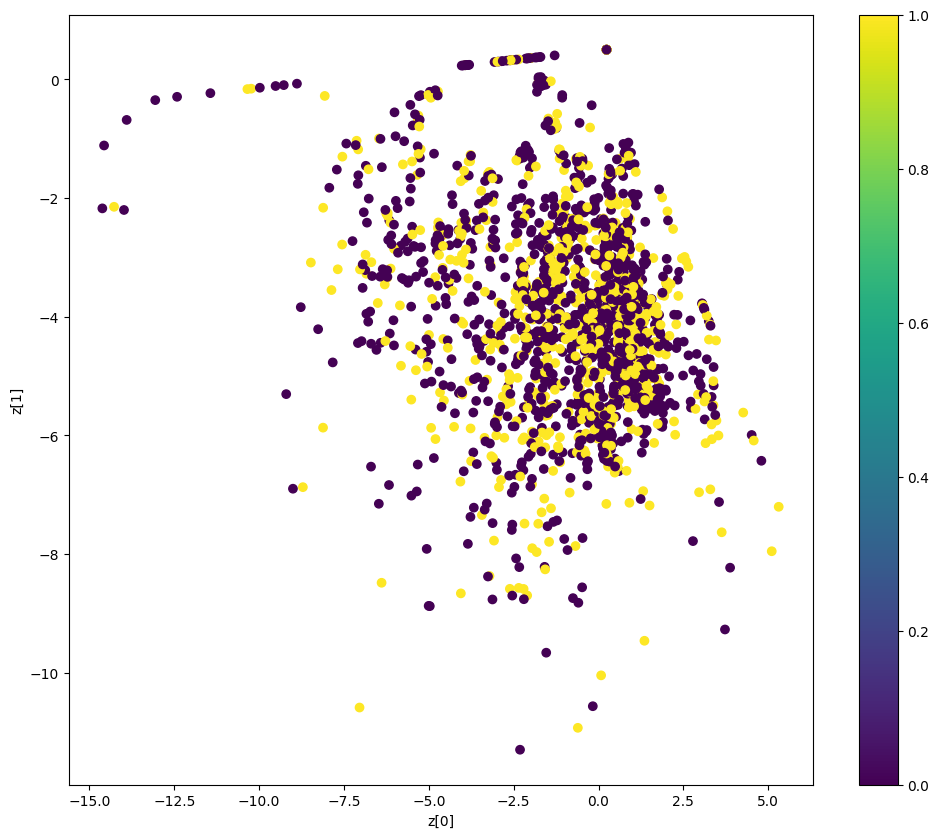

In [77]:
# Code taken from: https://keras.io/examples/generative/vae/
# 1.0 = stroke, 0.0 = normal
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, training_imgs, train_labels)

This model did not perform up to standards. While its error did go down as training progressed, it still did not reach any usable level of accuracy and appears to be only marginally better than guessing.

Possible reasons why this model failed:
- There was not enough training data
- The head scan images are too different from each other
  - (see, for example, brain scan images that intersect through the eyes and sinuses, or the images that only intersect the top-most portion of the brain).
- The differences between stroke and normal brain images are too difficult to discern, by humans or by the VAE.

If you look at the Jupyter Notebooks I had for verifying the "detect brain tumors with CNNs" paper, and if you look at the images used, you might notice:
- the brain tumors are much more noticeable visually

That might explain why that model(s) worked much better.

Possible routes of improvement:
- Adapt the simple CNN from the Keras MNIST tutorial and hope that it offers better results
- Find more brain scan images to train the VAE with